# UCM model selection

Here we perform model selection over different basis expansions in the UCM evaluated on real neural data.

To train the models, run in command line:

```
python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-el-3 --mapping svgp-64 --x_mode hd-omega-speed-x-y-time --lr 1e-2 --jitter 1e-5 --gpu 0

python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-eq-3 --mapping svgp-64 --x_mode hd-omega-speed-x-y-time --lr 1e-2 --jitter 1e-5 --gpu 0

python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-ec-3 --mapping svgp-64 --x_mode hd-omega-speed-x-y-time --lr 1e-2 --jitter 1e-5 --gpu 0

python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-el-1 --mapping svgp-64 --x_mode hd-omega-speed-x-y-time --lr 1e-2 --jitter 1e-5 --gpu 0

python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-el-2 --mapping svgp-64 --x_mode hd-omega-speed-x-y-time --lr 1e-2 --jitter 1e-5 --gpu 0

python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-el-4 --mapping svgp-64 --x_mode hd-omega-speed-x-y-time --lr 1e-2 --jitter 1e-5 --gpu 0
```



In [1]:
import torch

import matplotlib.pyplot as plt

import scipy.special as sps
import scipy.stats as scstats
import numpy as np

import sys
sys.path.append("../scripts/") # access to scripts
    

import neuroprob as nprb
from neuroprob import utils


device = nprb.inference.get_device(gpu=0)

import models


PyTorch version: 1.13.1+cu117
Using device: cuda:0


### Loading models

Here we specify the dataset used for training and the model architecture hyperparameters. This model is the UCM fit to observed covariates ```x_mode = 'hd-w-s-pos-t'```, meaning head direction (```hd```), angular head velocity (```w```), speed (```s```), animal $x$ and $y$ position (```pos```, two dimensions), and absolute time since the start of the recording session (```t```).

In [2]:
data_path = '../data/'
data_type = 'th1'
bin_size = 40

dataset_dict = models.get_dataset(data_type, bin_size, data_path)

In [3]:
checkpoint_dir = '../scripts/checkpoint/'
config_name = 'th1_U-el-4_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f-1'
batch_info = 500


full_model, training_loss, fit_dict, val_dict = models.load_model(
    config_name,
    checkpoint_dir,
    dataset_dict,
    batch_info,
    device,
)

FileNotFoundError: [Errno 2] No such file or directory: '../scripts/checkpoint/th1_U-el-4_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f-1.pt'

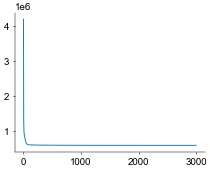

In [6]:
plt.plot(training_loss)

### Cross-validation

In [7]:
cvs = [1, 2, 3, 5, 6, 8]
batch_info = 500

config_names = [
    'th1_U-el-1_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-el-2_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-el-3_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-el-4_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-eq-3_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
]


Ell = []
for name in config_names:
    full_model, training_loss, fit_dict, val_dict = models.load_model(
        name,
        checkpoint_dir,
        dataset_dict,
        batch_info,
        device,
    )
    
    Ell.append(
        models.RG_pred_ll(
            full_model,
            val_dict,
            neuron_group=None,
            ll_mode="GH",
            ll_samples=100,
            cov_samples=1,
            beta=0.0,
        )
    )
    
Ell = np.array(Ell).reshape(-1, len(cvs))

<ErrorbarContainer object of 3 artists>

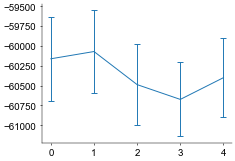

In [8]:
plt.errorbar(np.arange(Ell.shape[0]), Ell.mean(-1), yerr=Ell.std(-1) / np.sqrt(len(cvs)), capsize=3)